### 把通过坐标和自行筛选出来的样本叠加在DSS图像上看看

In [1]:
from laspec.mpl import set_cham
set_cham(latex=False)

In [2]:
from astropy import table

l12_m31_g3_pm = table.Table.read("m31/lamost/l12_m31_gedr3_pm0.5_rv_v2.fits")

ra = l12_m31_g3_pm["ra"]
dec = l12_m31_g3_pm["dec"]
rv = l12_m31_g3_pm["z"]*299792.458

INFO: Auto-setting vmin to  2.036e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.493e+04 [aplpy.core]


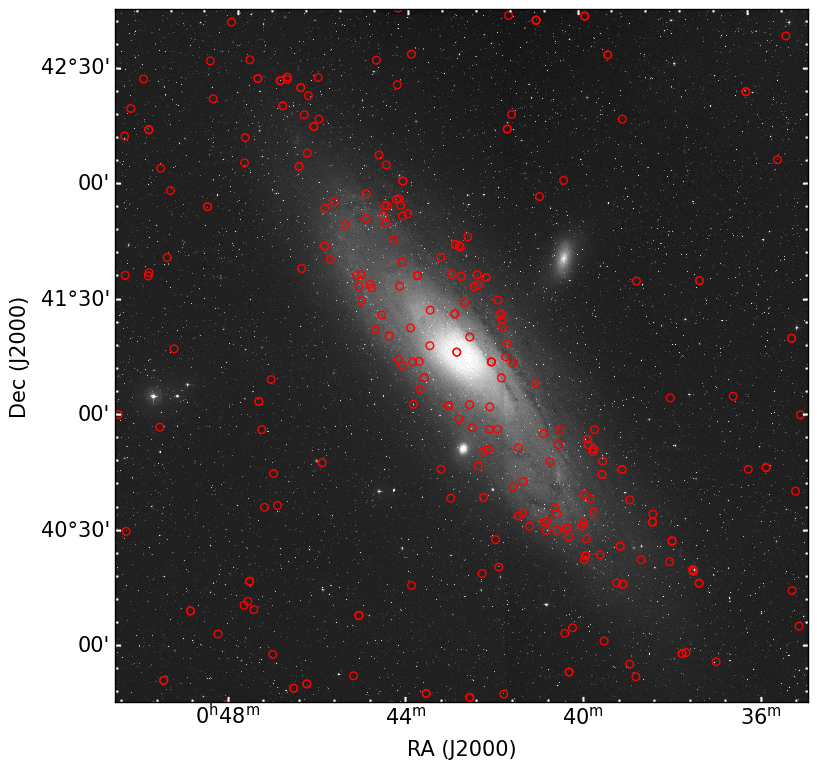

In [3]:
import aplpy
gc = aplpy.FITSFigure("m31/dss/skv2177985231060-DSS2Red.fits")
gc.show_grayscale()
gc.show_markers(l12_m31_g3_pm["ra"], l12_m31_g3_pm["dec"])

In [4]:
# 读取DSS（Digital Sky Survey, 数字巡天）的R波段图像文件
from astropy.io import fits
hl = fits.open("m31/dss/skv2177985231060-DSS2Red.fits")
hl.info()

Filename: m31/dss/skv2177985231060-DSS2Red.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     142   (1200, 1200)   float32   


### 获取图像数据和WCS坐标

In [5]:
from astropy.wcs import WCS
import numpy as np
image_data = np.log10(hl[0].data)  # 获取图像数据数组
header = hl[0].header    # 获取FITS头信息（含坐标系统）

# 创建世界坐标系统（WCS）对象
wcs = WCS(header)

# 提取坐标轴标签（如赤经/赤纬）
ra_label = "RA (J2000)"
dec_label = "Dec (J2000)"

### 画出DSS图像

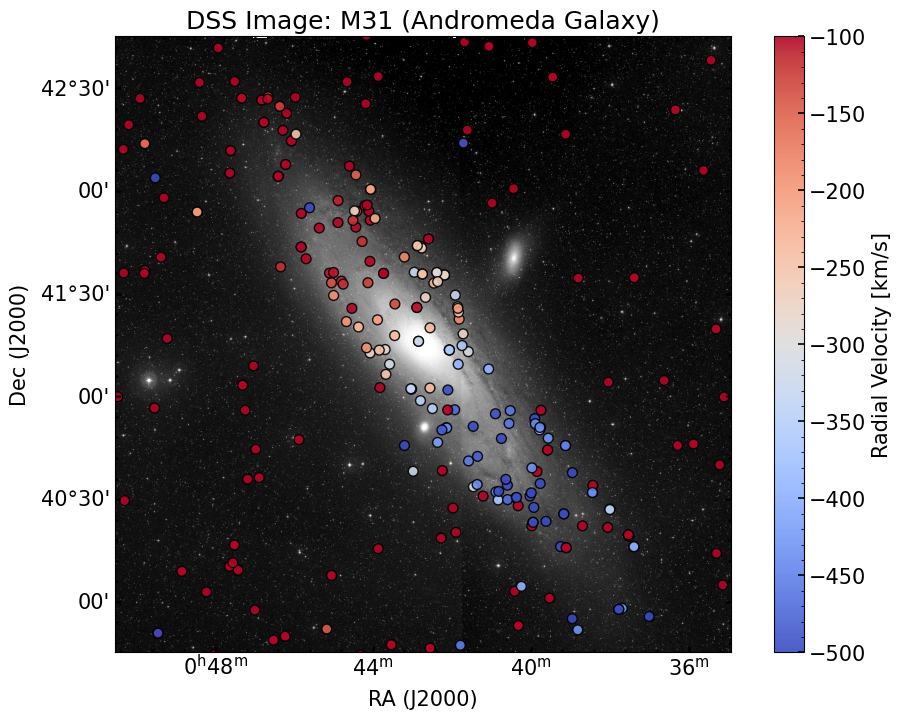

In [6]:
import matplotlib.pyplot as plt
from laspec.mpl import set_cham
set_cham(latex=False)

# 创建带天文坐标的绘图画布
fig = plt.figure(figsize=(11, 8), dpi=100)
ax = fig.add_subplot(111, projection=wcs)

# 绘制DSS图像（使用灰度色图，调整对比度）
im = ax.imshow(
    image_data,
    cmap='gray',
    origin='lower',
    vmin=np.nanpercentile(image_data, 5),  # 增强暗部细节
    vmax=np.nanpercentile(image_data, 99.9)  # 抑制亮部过曝
)

# 设置坐标轴标签
ax.set_xlabel(ra_label)
ax.set_ylabel(dec_label)
ax.set_title("DSS Image: M31 (Andromeda Galaxy)")

# 添加网格线和色标
# ax.grid(color='white', linestyle='--', alpha=0.3)
# fig.colorbar(im, ax=ax, label='Flux')

# 假设 wcs 是已定义的WCS投影对象
pixel_coords = wcs.wcs_world2pix(np.column_stack([ra, dec]), 0)  # 0表示原点在左下角
x_pix, y_pix = pixel_coords[:, 0], pixel_coords[:, 1]


RV_SPAN = 200
RV_TRUTH = -300

# 绘制散点图时使用转换后的像素坐标
sc = ax.scatter(
    x_pix, y_pix, c=rv, s=50, alpha=0.9, marker="o", edgecolor="k",
    vmin=RV_TRUTH-RV_SPAN, vmax=RV_TRUTH+RV_SPAN, cmap='coolwarm'
)

ax.set_xlim(0, image_data.shape[1])  # x轴范围=图像宽度（像素）
ax.set_ylim(0, image_data.shape[0])  # y轴范围=图像高度（像素）
ax.set_aspect('equal')                # 强制等比例防止形变[7,8](@ref)

fig.colorbar(sc, ax=ax, label="Radial Velocity [km/s]")

# 显示图像
plt.show()
fig.tight_layout()
fig.savefig("m31/figs/dss_rv.pdf", dpi=300)
fig.savefig("m31/figs/dss_rv.png", dpi=300)